# Import all of the libraries and packages you'll need

In [24]:
import numpy
import scipy.stats # for calculating t-tests and other statistics
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.cm as cm
import glob
import datetime as dt

mp.rcParams.update({'mathtext.default': 'regular'}) # use sans serif with Latex fonts
degree_sign= u'\N{DEGREE SIGN}'


In [25]:
#Hack to fix missing PROJ4 env var
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits import basemap

define some variables for plotting

In [77]:
model_name = 'CESM2'
varname = 'tos'
variable_full_name = 'SST'

* Input file path and names for models


In [65]:
varname = 'tos'
file_root = '/home/datasets/aos112_2020/extra_cmip6_data/'

hist_file = 'tos_Amon_CESM2_hist_185001-201412_1.0x1.0.nc'


rcp_file = 'tos_Amon_CESM2_ssp585_201501-210001_1.0x1.0.nc'

* Extract lat and lon info from one of the model output

In [66]:
# get lat/lon info
ncfile = netCDF4.Dataset(file_root+hist_file, 'r', format='NETCDF4') # notice how you can concatenate strings, + , and index lists , pr_hist[0]
model_lat = ncfile.variables['lat'][:]
model_lon = ncfile.variables['lon'][:]
model_lon = numpy.clip(model_lon,.001,359.999) # fixes a strange bug in the basemap plotting

# Specify time periods and season
* Change season and months
* Re-open model data after change

In [67]:
hist_start = dt.datetime(1970,1,1)
hist_end = dt.datetime(2000,1,1)

rcp_start = dt.datetime(2070,1,1)
rcp_end = dt.datetime(2100,1,1)

#season='DJF'; months=[12,1,2]
#season='MAM'; months=[3,4,5]
#season='JJA'; months=[6,7,8]
#season='SON'; months=[9,10,11]
season='annual'; months=[1,2,3,4,5,6,7,8,9,10,11,12]

In [68]:
ncfile.variables

{'time': <class 'netCDF4._netCDF4.Variable'>
 float64 time(time)
     units: days since 0001-01-01 00:00:00
     calendar: 365_day
 unlimited dimensions: 
 current shape = (1980,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'lon': <class 'netCDF4._netCDF4.Variable'>
 float64 lon(lon)
     units: degree
 unlimited dimensions: 
 current shape = (360,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'lat': <class 'netCDF4._netCDF4.Variable'>
 float64 lat(lat)
     units: degree
 unlimited dimensions: 
 current shape = (180,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'tos': <class 'netCDF4._netCDF4.Variable'>
 float64 tos(time, lat, lon)
 unlimited dimensions: 
 current shape = (1980, 180, 360)
 filling on, default _FillValue of 9.969209968386869e+36 used}

# Open model data for temperature
* Open historical months for all models for season specified above
* Re-open model data after changing season
* This cell takes a while to complete

In [71]:
# OPEN HISTORICAL PERIOD pr DATA
modelname = model_name
ncfile = netCDF4.Dataset(file_root+hist_file, 'r', format='NETCDF4')
hist_data = ncfile.variables[varname][:,:,:]
time_variable = ncfile.variables['time']
date_start = netCDF4.date2num(hist_start, time_variable.units, time_variable.calendar)
date_end = netCDF4.date2num(hist_end, time_variable.units, time_variable.calendar)
model_time = time_variable[:]

time_variable_converted = netCDF4.num2date(time_variable[:], time_variable.units, time_variable.calendar)

time_indices = numpy.array([(t.month in months)&(t.year in range(hist_start.year, hist_end.year+1)) for t in time_variable_converted])
hist_data_seas = hist_data[time_indices,:,:]
hist_months = hist_data_seas

* Open SSP585 months for all models for season specified above
* Re-open model data after changing season
* This cell takes a while to complete

In [72]:
ncfile = netCDF4.Dataset(file_root + rcp_file, 'r', format='NETCDF4')
rcp_data = ncfile.variables[varname][:,:,:]
time_variable = ncfile.variables['time']
date_start = netCDF4.date2num(rcp_start, time_variable.units, time_variable.calendar)
date_end = netCDF4.date2num(rcp_end, time_variable.units, time_variable.calendar)
model_time = time_variable[:]

time_variable_converted = netCDF4.num2date(time_variable[:], time_variable.units, time_variable.calendar)

time_indices = numpy.array([(t.month in months)&(t.year in range(rcp_start.year, rcp_end.year+1)) for t in time_variable_converted])
rcp_data_seas = rcp_data[time_indices,:,:]
rcp_months = rcp_data_seas


# Calculate climatologies for historical and  SSP585 fields

In [73]:
# create empty lists to store the climatologies, anomalies, 
# and p-values for a statistical significance test


# calculate the fields listed above for each model, 
#  and "append" the results to the existing lists
# uncomment the print line below to see how the size of the lists change with i
#print(tas_hist_months_list[i].shape, tas_rcp_months_list[i].shape)
hist_clim = numpy.mean(hist_months, axis=0) # calculate time-mean (0-th axis=time)
rcp_clim = numpy.mean(rcp_months, axis=0)
anoms = rcp_clim - hist_clim
pvals =scipy.stats.ttest_ind(hist_months, rcp_months, axis=0)[1]

# The last line calculate the t-test to determine whether 
#  the precipitation distribution under historical forcings
#  is significantly different from that under global warming conditions
# To know more, google "scipy.stats.ttest_ind" or "student's t-test"

/home/twemmen/anaconda3/envs/aos112/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/twemmen/anaconda3/envs/aos112/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/twemmen/anaconda3/envs/aos112/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


* Plot

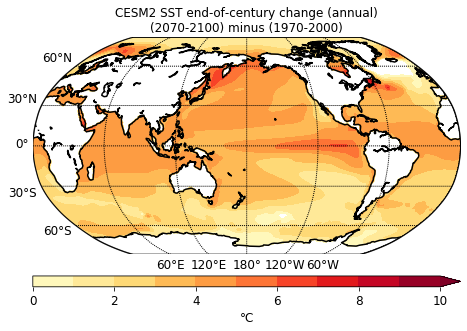

In [78]:
fig = mp.figure(figsize=(7,4.5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(0,11,1)
tas_map = map.contourf(xi,yi,anoms,cmap='YlOrRd', levels=contour_levels, extend='max')
cbar = map.colorbar(tas_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(degree_sign+'C', fontsize=12)
ax.set_title(model_name+ ' ' + variable_full_name + ' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)

fig.tight_layout()
#mp.savefig('plots/tas_anoms_'+model_names[model_index]+'_'+season+'.pdf', transparent=True, bbox_inches='tight')

# Plot end-of-century minus historical with stippling where the grid points pass a statistical significance test

* The test used here is a Student's *t* test for difference in means between the historical and end-of-century months.  It is calculated in the __Calculate climatologies...__ boxes above.
* By default keeps the same model as above (to change, uncomment the __`model_index=`__ line and choose model)
* The default significance level is 95% (set __`sig_level=`__ to be 1 minus significance level)

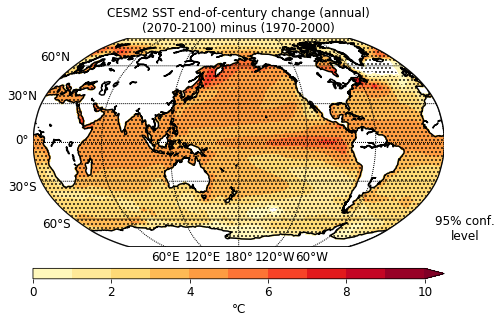

In [82]:
sig_level = 5 # 95% confidence means sig_level = 5

fig = mp.figure(figsize=(7,4.5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(0,11,1)

tas_map = map.contourf(xi,yi,anoms,cmap='YlOrRd', levels=contour_levels, extend='max')
tas_signif = map.contourf(xi,yi,pvals, colors='none', levels=[0.0,sig_level/100.,1.0], hatches=['...',None], extend='lower')

cbar = map.colorbar(tas_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(degree_sign+'C', fontsize=12)
ax.set_title(model_name+ ' ' + variable_full_name +  ' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)
ax.text(s=str(100-sig_level)+'% conf.\nlevel', x=0.93, y=0.25, ha='center', va='bottom', transform=fig.transFigure, fontsize=12)

fig.tight_layout()
#mp.savefig('plots/tas_anoms_'+model_names[model_index]+'_'+season+'_signif_stippling.pdf', transparent=True, bbox_inches='tight')

# Temperature change zoomed in
* Change __lat__/__lon__, and __sig_level__
* By default keeps the same model as above (to change, uncomment the __`model_index=`__ line and choose model)

In [89]:
lat_lo = 40
lat_hi = 80
lon_lo = 270
lon_hi = 360

# model_index = 8

sig_level = 5 # 95th confidence means sig_level = 5

In [ ]:
fig = mp.figure(figsize=(7,4.5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',llcrnrlat=lat_lo,urcrnrlat=lat_hi,llcrnrlon=lon_lo,urcrnrlon=lon_hi,resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,30.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
map.drawstates()
map.drawcountries()
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(-5,5,1)

tas_map = map.contourf(xi,yi,anoms,cmap='seismic', levels=contour_levels, extend='both')
tas_signif = map.contourf(xi,yi,pvals, colors='none', levels=[0.0,sig_level/100.,1.0], hatches=['...',None], extend='lower')

cbar = map.colorbar(tas_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(degree_sign+'C', fontsize=12)
ax.set_title(model_name+ ' ' + variable_full_name + ' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)
ax.text(s=str(100-sig_level)+'% conf.\nlevel', x=0.93, y=0.25, ha='center', va='bottom', transform=fig.transFigure, fontsize=12)

fig.tight_layout()
#mp.savefig('plots/tas_anoms_'+model_names[model_index]+'_'+season+'_signif_stippling_ZOOM.pdf', transparent=True, bbox_inches='tight')